# Predicting Bullying Amongst Students In School.

The goal of the project is to create a machine learning model that can well identify whether a student is being bullied or not. For this project different strategies have been tried to arrive at the best model to use in making predictions. The models to be used range from a simple logistic regression model, to a custom made model that combines the predictions of two models. 
There is also the dilemma of recall vs precision, these two classification metrics have an inverse relationship and optimising for one leads to reduction of the other. The primary metric that will be used in evaluating the models is the ROCAUC score. Since the data being used is an imbalanced data set, this gives a better evaluation on how well the models perform. 

There will be two approach used in tackling the problem of the imbalanced data set. 
1. To perform hyperparameter tuning and give weighting to the different classes to be predicted.
2. Resampling the training data by both under sampling it and over sampling it.

### Summary
* There were three models that stood out after training the data and they were the logistic regression model, SVC and the xgboost model.
* The SVC model had the best performance. Even after tuning both the logistic regression and xgboost model they could not perfrom better than the SVC model.
* Resampling the data by either over sampling, under sampling or both combined did not provide improvement to the models.

In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer 
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
bullying = pd.read_csv("bullying.csv")

In [3]:
bullying.head()

,record,bullied_in_school,bullied_not_school,cyber_bullied,custom_age,sex,physically_attacked,physical_fighting,felt_lonely,close_friends,missed_school,other_students_kind_and_helpful,parents_understand_problems,most_of_the_time_or_always_felt_lonely,missed_classes,were_underweight,were_overweight,were_obese
0,1,Yes,Yes,NaN,13 years old,Female,0 times,0 times,Always,2,10 or more days,Never,Always,Yes,Yes,NaN,NaN,NaN
1,2,No,No,No,13 years old,Female,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,NaN,NaN,NaN
2,3,No,No,No,14 years old,Male,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,No,No,No
3,4,No,No,No,16 years old,Male,0 times,2 or 3 times,Never,3 or more,0 days,Sometimes,NaN,No,No,No,No,No
4,5,No,No,No,13 years old,Female,0 times,0 times,Rarely,3 or more,0 days,Most of the time,Most of the time,No,No,NaN,NaN,NaN


###  Cleaning Data and Handling Null Values

In [4]:
bullying.isnull().sum()/bullying.shape[0] * 100

record                                     0.000000
bullied_in_school                          2.174409
bullied_not_school                         0.858181
cyber_bullied                              1.002088
custom_age                                 0.189537
sex                                        0.940664
physically_attacked                        0.421193
physical_fighting                          0.470332
felt_lonely                                0.642319
close_friends                              1.888349
missed_school                              3.271266
other_students_kind_and_helpful            2.736000
parents_understand_problems                4.164546
most_of_the_time_or_always_felt_lonely     0.642319
missed_classes                             3.271266
were_underweight                          36.729787
were_overweight                           36.729787
were_obese                                36.729787
dtype: float64

The columns with more than 5% of null values are going t be dropped. This includes the `were_obese`, `were_underweight`, `were_overweight` columns. From the EDA done which can be found <a href="https://github.com/yickysan/MLops/blob/main/notebook/Exploratory%20data%20analysis.ipynb">here</a> , these columns are not indicative of bullying. For the rest of the dataset, the null entries will be dropped. 

In [5]:
bullying.drop(
    ["were_obese", "were_underweight", "were_overweight"],
    axis=1, inplace=True
)
bullying.dropna(inplace=True)

In [6]:
bullying.isnull().sum()

record                                    0
bullied_in_school                         0
bullied_not_school                        0
cyber_bullied                             0
custom_age                                0
sex                                       0
physically_attacked                       0
physical_fighting                         0
felt_lonely                               0
close_friends                             0
missed_school                             0
other_students_kind_and_helpful           0
parents_understand_problems               0
most_of_the_time_or_always_felt_lonely    0
missed_classes                            0
dtype: int64

In [7]:
bullying.drop(
    ["record", "most_of_the_time_or_always_felt_lonely", "missed_classes"],
    axis=1, inplace=True
)

In [8]:
bullying.shape

(50754, 12)

## Creating Features and Target Variable

In [9]:
y = bullying["bullied_in_school"].astype("category").cat.codes
X = bullying.copy().drop("bullied_in_school", axis=1)

In [10]:
y.value_counts(normalize=True)

0    0.789731
1    0.210269
dtype: float64

The data set is imbalanced with only 21% of the data being students that were bullied.

In [11]:
cat_cols = X.select_dtypes(include=["object"]).columns
ohe = OneHotEncoder(sparse=False)

col_transformer= ColumnTransformer([
    ("cat", ohe, cat_cols)
])

X = col_transformer.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [13]:
X_train_df = pd.DataFrame(X_train, columns = col_transformer.named_transformers_["cat"].get_feature_names_out())
X_test_df = pd.DataFrame(X_test, columns = col_transformer.named_transformers_["cat"].get_feature_names_out())


## Evaluating Models

In [14]:
scale_pos_weight = y.value_counts().values[0]/y.value_counts().values[1]

The `scale_pos_weight` argument for the xgboost model accounts for the imbalance nature of the dataset. As a rule of thumb, a good `scale_pos_weight` value is the ratio of the majority class over the minority class. For the other models, the `class_weight` argument will be set to `balanced`.

In [15]:
models = {
    "logreg" : LogisticRegression(class_weight="balanced"),
    "randomforest" : RandomForestClassifier(class_weight="balanced", random_state=1),
    "adaboost" : AdaBoostClassifier(random_state=1),
    "xgboost" : XGBClassifier(scale_pos_weight = scale_pos_weight, random_state=1),
    "svm" : SVC(class_weight="balanced", random_state=1),
    "tree" : DecisionTreeClassifier(random_state=1, class_weight="balanced")
}

In [16]:
model_performance = {}
# loop through each item in the dictionary and use the models for prediction
for k, v in models.items():
    model_dict = {}
    model_name = k
    model = v
    model.fit(X_train, y_train) # fit the model with training data
    pred = model.predict(X_test)
    model_dict["auc_score"] = roc_auc_score(y_test, pred)
    model_dict["precision_score"] = precision_score(y_test, pred)
    model_dict["recall_score"] = recall_score(y_test, pred)
    model_dict["confusion_matrix"] = confusion_matrix(y_test, pred)
    model_performance[model_name] = model_dict

In [17]:
for key in model_performance.keys():
    print(key, ": ", "\n",
          "auc_score: %.4f" %model_performance[key]["auc_score"], "\n", 
          "recall_score: %.4f" %model_performance[key]["recall_score"], "\n",
          "precision_score: %.4f" %model_performance[key]["precision_score"], "\n",
            model_performance[key]["confusion_matrix"])
    print("---------------------------")

logreg :  
 auc_score: 0.7109 
 recall_score: 0.6499 
 precision_score: 0.4383 
 [[6152 1817]
 [ 764 1418]]
---------------------------
randomforest :  
 auc_score: 0.6280 
 recall_score: 0.3758 
 precision_score: 0.4622 
 [[7015  954]
 [1362  820]]
---------------------------
adaboost :  
 auc_score: 0.6211 
 recall_score: 0.2901 
 precision_score: 0.6236 
 [[7587  382]
 [1549  633]]
---------------------------
xgboost :  
 auc_score: 0.7015 
 recall_score: 0.6306 
 precision_score: 0.4313 
 [[6155 1814]
 [ 806 1376]]
---------------------------
svm :  
 auc_score: 0.7165 
 recall_score: 0.6682 
 precision_score: 0.4376 
 [[6095 1874]
 [ 724 1458]]
---------------------------
tree :  
 auc_score: 0.6058 
 recall_score: 0.4216 
 precision_score: 0.3547 
 [[6295 1674]
 [1262  920]]
---------------------------


The xgboost, svm and logistic regresion models performed best. Some hyperparameter tuning will be performed to see if the model performance can be improved.

## Hyperparameter Optimization.

### XGB Hyperparameter Optimization

In [18]:
learning_rate = [i/100 for i in range(1, 11)]
gamma = [i/10 for i in range(5)]
max_depth = range(3, 10, 2)
min_child_weight = range(1, 8, 2)
reg_alpha =[1e-5, 1e-2, 0.1, 1, 100]
subsample =[i/100 for i in range(75, 90, 5)]
colsample_bytree = [i/100 for i in range(75, 90, 5)]
scale_pos_weights = [1, 2, 3, 4, scale_pos_weight]

xgb_model = models["xgboost"]



In [19]:
%%time
xgb_param = {"n_estimators" : range(100, 550, 50)}
xgb_gridsearch = GridSearchCV(xgb_model, xgb_param, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch.fit(X, y)

print(xgb_gridsearch.best_score_)
print(xgb_gridsearch.best_params_)

0.7579010292094389
{'n_estimators': 100}
CPU times: total: 17.1 s
Wall time: 16min 51s


In [20]:
%%time
xgb_model2 = xgb_gridsearch.best_estimator_
xgb_param2 = {"max_depth" : max_depth,
              "min_child_weight" : min_child_weight
             }
xgb_gridsearch2 = GridSearchCV(xgb_model2, xgb_param2, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch2.fit(X, y)

print(xgb_gridsearch2.best_score_)
print(xgb_gridsearch2.best_params_)

0.7755177408726329
{'max_depth': 3, 'min_child_weight': 7}
CPU times: total: 9.58 s
Wall time: 10min 14s


In [21]:
%%time
xgb_model3 = xgb_gridsearch2.best_estimator_
xgb_param3 = {"learning_rate" : learning_rate,
              "gamma" : gamma }
xgb_gridsearch3 = GridSearchCV(xgb_model3, xgb_param3, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch3.fit(X, y)

print(xgb_gridsearch3.best_score_)
print(xgb_gridsearch3.best_params_)

0.7769757808446022
{'gamma': 0.0, 'learning_rate': 0.08}
CPU times: total: 13.2 s
Wall time: 15min 32s


In [22]:
%%time
xgb_model4 = xgb_gridsearch3.best_estimator_
xgb_param4 = {"reg_alpha" : reg_alpha,
              "subsample" : subsample,}
xgb_gridsearch4 = GridSearchCV(xgb_model4, xgb_param4, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch4.fit(X, y)

print(xgb_gridsearch4.best_score_)
print(xgb_gridsearch4.best_params_)

0.7774898864224424
{'reg_alpha': 0.1, 'subsample': 0.75}
CPU times: total: 10.8 s
Wall time: 4min 56s


In [23]:
%%time
xgb_model5 = xgb_gridsearch4.best_estimator_
xgb_param5 = {"colsample_bytree" : colsample_bytree,
             "scale_pos_weight" : scale_pos_weights}
xgb_gridsearch5 = GridSearchCV(xgb_model5, xgb_param5, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch5.fit(X, y)

print(xgb_gridsearch5.best_score_)
print(xgb_gridsearch5.best_params_)

0.7771881407915773
{'colsample_bytree': 0.85, 'scale_pos_weight': 2}
CPU times: total: 10.8 s
Wall time: 4min 21s


the parameters from the 4th iteration of the grid search for the xgboost model had the best auc_score and so that is the xgboost model that will be used.

In [24]:
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, learning_rate=0.08,
                         gamma=0.0, reg_alpha=0.1, subsample=0.75,
                         max_depth=3, min_child_weight=7)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

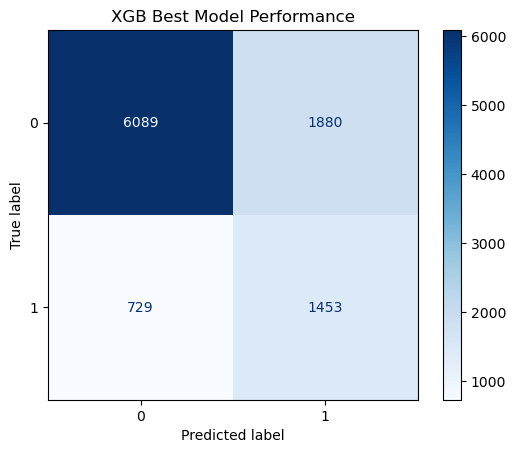

auc_score: 0.7150 recall_score : 0.6659 accuracy_score: 0.7430 precision_score : 0.4359


In [25]:
xgb_model_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, xgb_pred))
xgb_model_plot.plot(cmap=plt.cm.Blues)
xgb_model_plot.ax_.set_title("XGB Best Model Performance")
plt.show()

print(
    "auc_score: %.4f" % roc_auc_score(y_test, xgb_pred),
    "recall_score : %.4f" %recall_score(y_test, xgb_pred),
    "accuracy_score: %.4f" % accuracy_score(y_test, xgb_pred),
    "precision_score : %.4f" %precision_score(y_test, xgb_pred)
    
)

After performing hyperparameter tuning on the xgboost model, there is a slight impovement and the model can better predict the minority class but the difference in model performance isn't really significant.

### LogisticRegression Hyperparameter Tuning

In [26]:
lgr_clf = models["logreg"]

fit_intercept = [True, False]
penalty = ["l1", "l2", "elasticnet"]
solver = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
class_weights = [{0:1, 1:99}, {0:10, 1:90}, {0:5, 1:95},
                {0:15, 1:85}, {0:20, 1:80}, {0:25,1:75},
                {0:19, 1:71}, {0:21, 1:69}, {0:11, 1:79}]

In [27]:
%%time
lgr_param = {"penalty" : penalty,
            "solver" : solver,
            "fit_intercept" : fit_intercept}
lgr_gridsearch = GridSearchCV(lgr_clf, lgr_param, cv=10, scoring="roc_auc", n_jobs=-1)
lgr_gridsearch.fit(X, y)

print(lgr_gridsearch.best_score_)
print(lgr_gridsearch.best_params_)

0.7606219943957291
{'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
CPU times: total: 3.62 s
Wall time: 1min 41s


In [28]:
%%time
lgr_clf2 = lgr_gridsearch.best_estimator_
lgr_param2 = {"class_weight" : class_weights}
lgr_gridsearch2 = GridSearchCV(lgr_clf2, lgr_param2, cv=10, scoring="roc_auc", n_jobs=-1)
lgr_gridsearch2.fit(X, y)

print(lgr_gridsearch2.best_score_)
print(lgr_gridsearch2.best_params_)

0.7608458939101563
{'class_weight': {0: 1, 1: 99}}
CPU times: total: 1.55 s
Wall time: 28 s


In [34]:
lgr_gridsearch2.best_estimator_.fit(X_train, y_train)
lgr_pred = lgr_gridsearch2.best_estimator_.predict(X_test)
print(roc_auc_score(y_test, lgr_pred))
print(confusion_matrix(y_test, lgr_pred))

0.5
[[   0 7969]
 [   0 2182]]


Despite the second logistic regression model performing better and having a better auc_score with the class weights in the grid_search. It doesn't do a good job at predicting the test data.

In [29]:
lgr_gridsearch.best_estimator_.fit(X_train, y_train)
lgr_pred = lgr_gridsearch.best_estimator_.predict(X_test)
print(roc_auc_score(y_test, lgr_pred))
print(confusion_matrix(y_test, lgr_pred))

0.7092029621198275
[[6256 1713]
 [ 800 1382]]


Infact the initial logistic regression model does a better job at predicting the test data than the logistic regression models after hyperparameter tuning.

In [30]:
log_model = models["logreg"]
log_pred = log_model.predict(X_test)

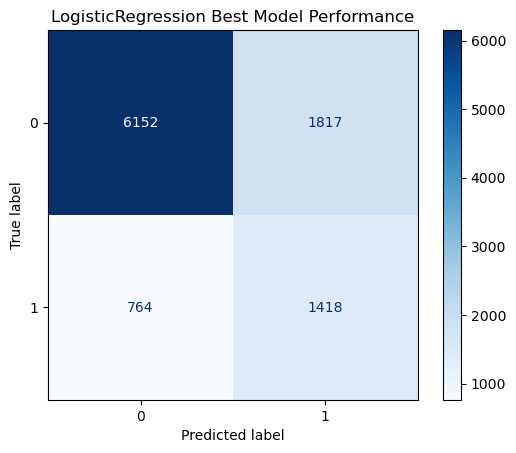

auc_score: 0.7109 recall_score : 0.6499 accuracy_score: 0.7457 precision_score : 0.4383


In [31]:
log_model_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, log_pred))
log_model_plot.plot(cmap=plt.cm.Blues)
log_model_plot.ax_.set_title("LogisticRegression Best Model Performance")
plt.show()

print(
    "auc_score: %.4f" % roc_auc_score(y_test, log_pred),
    "recall_score : %.4f" %recall_score(y_test, log_pred),
    "accuracy_score: %.4f" % accuracy_score(y_test, log_pred),
    "precision_score : %.4f" %precision_score(y_test, log_pred)
    
)

The logistic regression model somewhat matches the xgboost model. It has a slightly better accuracy and precision score but less recall score. In fact both models performance a roughly the same and the difference is negligible.

## Creating Custom Model.
The custom model will be a combination of both the xgboost model and the logistic regression model and also the svm model. The prediction for the custom model will be made by taking the average probability of the predictions made for each class. Probabilities greater than 0.5 will mean a prediction of 1 while probability less than or equal to 0.5 will mean a prediction of 0.

In [32]:
class CustomBagger:
    """
    Function to make predictions with two models using bagging technique.
    
    This function utilises one `sklearn.linear_model.LogisticRegression` model and an `xgboost.XGBClassifier` model to make
    predictions on the dataset. Predictions are made by taking the average probability prediction of both models.
    A value of 1 will be predicted if the probability is greater than 0.5, otherwise it will be 0.
    
    Attributes:
    ----------
    model_1 : 
        either an `xgboost.XGBClassifier` model or an `sklearn.linear_model.LogisticRegression` model
        
    model_2 :
        either an `xgboost.XGBClassifier` model or an `sklearn.linear_model.LogisticRegression` model
        
    Methods:
    -------
    fit(X_train, y_train)
        This method splits the dataset equally and fits the models with each half of the split dataset
        
    predict(y_test)
        This method returns the average prediction of both models
    """
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        
    def fit(self, X_train, y_train):
        size = X_train.shape[0] // 2 # splitting the train data into equal parts to fit in the two models
        X_train_1, y_train_1 = X_train[:size], y_train[:size]
        X_train_2, y_train_2 = X_train[size:], y_train[size:]
        
        self.model_1 = self.model_1.fit(X_train_1, y_train_1)
        self.model_2 = self.model_2.fit(X_train_2, y_train_2)
        
    def predict(self, y_test):
        model_1_pred = pd.Series(self.model_1.predict_proba(y_test)[:, 1], name="model_1_pred")
        model_2_pred = pd.Series(self.model_2.predict_proba(y_test)[:, 1], name="model_2_pred")
        pred_table = pd.concat([model_1_pred, model_2_pred], axis=1) # creates a pandas data frame with predicttions of both model
        predictions = pred_table.mean(axis=1) # takes the average of both predictions
        predictions = predictions.apply(lambda x: 1 if x > 0.5 else 0).values # predicts 1 for probability greater than 0.55
        
        return predictions
        
        

In [33]:
svm_model = SVC(probability=True, class_weight="balanced")

In [34]:
log_xgb_model = CustomBagger(xgb_model, log_model)

log_xgb_model.fit(X_train, y_train)

preds = log_xgb_model.predict(X_test)

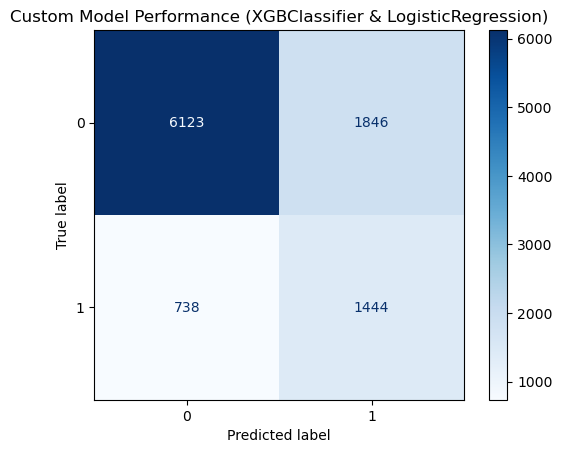

auc_score: 0.7151 recall_score : 0.6618 accuracy_score: 0.7454 precision_score : 0.4389


In [35]:
log_xgb_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, preds))
log_xgb_plot.plot(cmap=plt.cm.Blues)
log_xgb_plot.ax_.set_title("Custom Model Performance (XGBClassifier & LogisticRegression)")
plt.show()

print(
    "auc_score: %.4f" % roc_auc_score(y_test, preds),
    "recall_score : %.4f" %recall_score(y_test, preds),
    "accuracy_score: %.4f" % accuracy_score(y_test, preds),
    "precision_score : %.4f" %precision_score(y_test, preds)
    
)

In [36]:
log_svm_model = CustomBagger(svm_model, log_model)

log_svm_model.fit(X_train, y_train)

preds_1 = log_svm_model.predict(X_test)

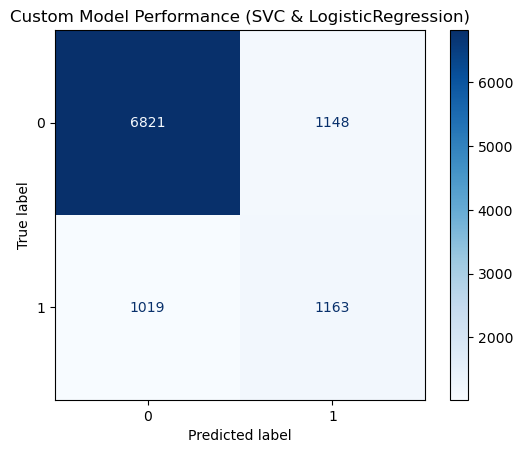

auc_score: 0.6945 recall_score : 0.5330 accuracy_score: 0.7865 precision_score : 0.5032


In [37]:
log_svm_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, preds_1))
log_svm_plot.plot(cmap=plt.cm.Blues)
log_svm_plot.ax_.set_title("Custom Model Performance (SVC & LogisticRegression)")
plt.show()

print(
    "auc_score: %.4f" % roc_auc_score(y_test, preds_1),
    "recall_score : %.4f" %recall_score(y_test, preds_1),
    "accuracy_score: %.4f" % accuracy_score(y_test, preds_1),
    "precision_score : %.4f" %precision_score(y_test, preds_1)
    
)

In [38]:
xgb_svm_model = CustomBagger(svm_model, xgb_model)

xgb_svm_model.fit(X_train, y_train)

preds_2 = xgb_svm_model.predict(X_test)

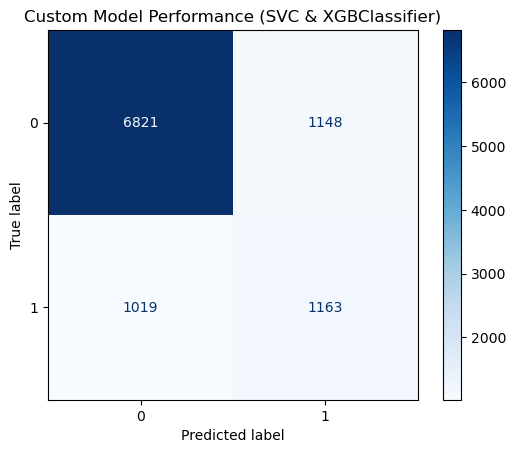

auc_score: 0.6892 recall_score : 0.5261 accuracy_score: 0.7821 precision_score : 0.4936


In [39]:
xgb_svm_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, preds_1))
xgb_svm_plot.plot(cmap=plt.cm.Blues)
xgb_svm_plot.ax_.set_title("Custom Model Performance (SVC & XGBClassifier)")
plt.show()

print(
    "auc_score: %.4f" % roc_auc_score(y_test, preds_2),
    "recall_score : %.4f" %recall_score(y_test, preds_2),
    "accuracy_score: %.4f" % accuracy_score(y_test, preds_2),
    "precision_score : %.4f" %precision_score(y_test, preds_2)
    
)

The custom models with either logistic regression or xgboost combined with the SVC model did not perform as good as the custom model built with the combination of xgboost and logistic regression. While this custom model with xgboost and logistu regression offered a slight improvement over both the stand alone xgboost and logistic regression model, it doesn't perform as wel as the stand alone SVC model.

## Model Explanation
This is to give a bit of insight on how the models makes predictions by and what features of the data has the most influence on the model's predictions

In [58]:
X_ex = bullying.copy().drop("bullied_in_school", axis=1)
for col in X_ex.columns:
    X_ex[col] = X_ex[col].astype("category").cat.codes
    

ex_train, ex_test = train_test_split(X_ex, test_size=0.2, random_state=1) 

In [62]:
xgb_ex = xgb_model
xgb_ex.fit(ex_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.08, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

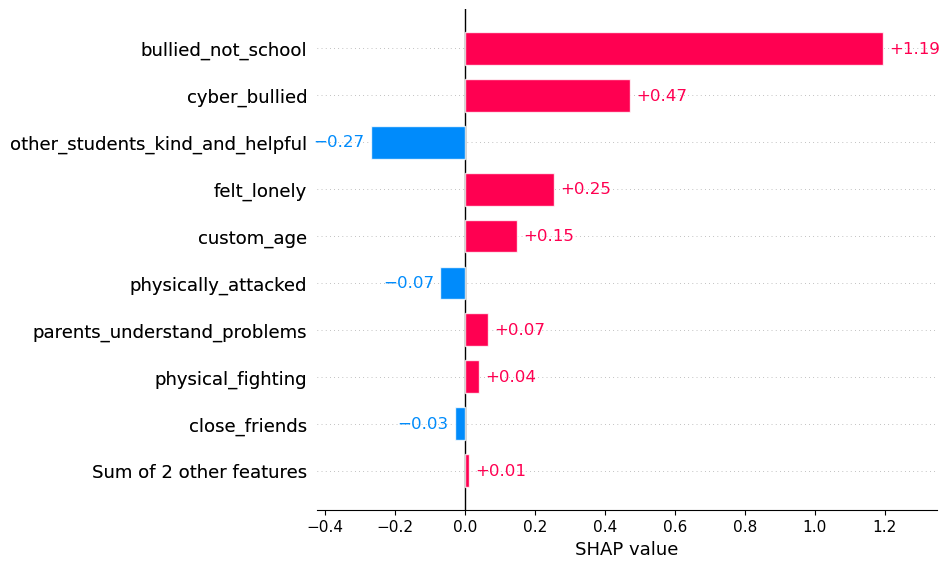

In [63]:
explainer = shap.TreeExplainer(xgb_ex)
shap_values = explainer(ex_test)
shap.plots.bar(shap_values[0])

Here we can see the top features that drive the model. Being cyber bullied or bullied outside school is a high indicator of whether a student will be bullied in school or not. Also their perception of other students being helpful or not can indicate bullying.

## Predicting Using Synthetic Minority Over Sampling (SMOTE) and Random Under Sampling

A combinantion of both smote over sampling and a random undersampling wil be performed on the train dataset before making predictions on the test dataset. The idea is to show how resampling the data can improve the model performamce on an imbalanced dataset.

### Over Sampling

In [38]:
over_sampler = SMOTE(sampling_strategy=0.8)
X_s, y_s = over_sampler.fit_resample(X_train, y_train)

In [39]:
y_s.value_counts()

0    32113
1    25690
dtype: int64

In [40]:
# the s in the variale names is to indicate they are from the resampled data
models_s = {
    "logreg" : LogisticRegression(),
    "randomforest" : RandomForestClassifier(random_state=1),
    "adaboost" : AdaBoostClassifier(random_state=1),
    "xgboost" : XGBClassifier(random_state=1),
    "svm" : SVC(random_state=1)
}

In [41]:
model_performance_s = {}
# loop through each item in the dictionary and use the models for prediction
for k, v in models_s.items():
    model_dict_s = {}
    model_name_s = k
    model_s = v
    model_s.fit(X_s, y_s) # fit the model with training data
    pred_s = model_s.predict(X_test)
    model_dict_s["auc_score"] = roc_auc_score(y_test, pred_s)
    model_dict_s["precision_score"] = precision_score(y_test, pred_s)
    model_dict_s["recall_score"] = recall_score(y_test, pred_s)
    model_dict_s["confusion_matrix"] = confusion_matrix(y_test, pred_s)
    model_performance_s[model_name_s] = model_dict_s

In [42]:
for key in model_performance_s.keys():
    print(key, ": ", "\n",
          "auc_score: %.4f" %model_performance_s[key]["auc_score"], "\n", 
          "recall_score: %.4f" %model_performance_s[key]["recall_score"], "\n",
          "precision_score: %.4f" %model_performance_s[key]["precision_score"], "\n",
            model_performance_s[key]["confusion_matrix"])
    print("---------------------------")

logreg :  
 auc_score: 0.7039 
 recall_score: 0.5930 
 precision_score: 0.4671 
 [[6493 1476]
 [ 888 1294]]
---------------------------
randomforest :  
 auc_score: 0.6342 
 recall_score: 0.3643 
 precision_score: 0.5099 
 [[7205  764]
 [1387  795]]
---------------------------
adaboost :  
 auc_score: 0.6913 
 recall_score: 0.5298 
 precision_score: 0.4964 
 [[6796 1173]
 [1026 1156]]
---------------------------
xgboost :  
 auc_score: 0.6337 
 recall_score: 0.3341 
 precision_score: 0.5786 
 [[7438  531]
 [1453  729]]
---------------------------
svm :  
 auc_score: 0.6574 
 recall_score: 0.3941 
 precision_score: 0.5764 
 [[7337  632]
 [1322  860]]
---------------------------


When the dataset was over sampled, there was improvement in the precision score which means a drop in recall but in generall, the overall model performance dropped from the original dataset. The only exception is the adaboost model which saw a slight improvement.

### Under Sampling.

In [43]:
under_sampler = RandomUnderSampler(sampling_strategy=0.8)
X_us, y_us = under_sampler.fit_resample(X_train, y_train)
y_us.value_counts()

0    10612
1     8490
dtype: int64

In [44]:
model_performance_us = {}
# loop through each item in the dictionary and use the models for prediction
for k, v in models_s.items():
    model_dict_us = {}
    model_name_us = k
    model_us = v
    model_us.fit(X_us, y_us) # fit the model with training data
    pred_us = model_us.predict(X_test)
    model_dict_us["auc_score"] = roc_auc_score(y_test, pred_us)
    model_dict_us["precision_score"] = precision_score(y_test, pred_us)
    model_dict_us["recall_score"] = recall_score(y_test, pred_us)
    model_dict_us["confusion_matrix"] = confusion_matrix(y_test, pred_us)
    model_performance_us[model_name_us] = model_dict_us

In [45]:
for key in model_performance_us.keys():
    print(key, ": ", "\n",
          "auc_score: %.4f" %model_performance_us[key]["auc_score"], "\n", 
          "recall_score: %.4f" %model_performance_us[key]["recall_score"], "\n",
          "precision_score: %.4f" %model_performance_us[key]["precision_score"], "\n",
            model_performance_us[key]["confusion_matrix"])
    print("---------------------------")

logreg :  
 auc_score: 0.7057 
 recall_score: 0.5944 
 precision_score: 0.4708 
 [[6511 1458]
 [ 885 1297]]
---------------------------
randomforest :  
 auc_score: 0.6832 
 recall_score: 0.6237 
 precision_score: 0.3989 
 [[5918 2051]
 [ 821 1361]]
---------------------------
adaboost :  
 auc_score: 0.7052 
 recall_score: 0.5903 
 precision_score: 0.4732 
 [[6535 1434]
 [ 894 1288]]
---------------------------
xgboost :  
 auc_score: 0.6957 
 recall_score: 0.6063 
 precision_score: 0.4359 
 [[6257 1712]
 [ 859 1323]]
---------------------------
svm :  
 auc_score: 0.7077 
 recall_score: 0.5940 
 precision_score: 0.4766 
 [[6546 1423]
 [ 886 1296]]
---------------------------


The under sampled dataset showed an improvement for most of the models and the performance was slightly close to that of the models that used the original dataset. Again the adaboost model benefitted the most from it.

In [46]:
over_sampler = SMOTE(sampling_strategy=0.6)
under_sampler = RandomUnderSampler(sampling_strategy=0.8)
pipe = Pipeline([("over", over_sampler), ("under", under_sampler)])
X_ds, y_ds = pipe.fit_resample(X_train, y_train)
y_ds.value_counts()

0    24083
1    19267
dtype: int64

In [47]:
model_performance_ds = {}
# loop through each item in the dictionary and use the models for prediction
for k, v in models_s.items():
    model_dict_ds = {}
    model_name_ds = k
    model_ds = v
    model_ds.fit(X_ds, y_ds) # fit the model with training data
    pred_ds = model_ds.predict(X_test)
    model_dict_ds["auc_score"] = roc_auc_score(y_test, pred_ds)
    model_dict_ds["precision_score"] = precision_score(y_test, pred_ds)
    model_dict_ds["recall_score"] = recall_score(y_test, pred_ds)
    model_dict_ds["confusion_matrix"] = confusion_matrix(y_test, pred_ds)
    model_performance_ds[model_name_ds] = model_dict_ds

In [48]:
for key in model_performance_ds.keys():
    print(key, ": ", "\n",
          "auc_score: %.4f" %model_performance_ds[key]["auc_score"], "\n", 
          "recall_score: %.4f" %model_performance_ds[key]["recall_score"], "\n",
          "precision_score: %.4f" %model_performance_ds[key]["precision_score"], "\n",
            model_performance_ds[key]["confusion_matrix"])
    print("---------------------------")

logreg :  
 auc_score: 0.7018 
 recall_score: 0.5880 
 precision_score: 0.4662 
 [[6500 1469]
 [ 899 1283]]
---------------------------
randomforest :  
 auc_score: 0.6508 
 recall_score: 0.4244 
 precision_score: 0.4861 
 [[6990  979]
 [1256  926]]
---------------------------
adaboost :  
 auc_score: 0.6946 
 recall_score: 0.5422 
 precision_score: 0.4925 
 [[6750 1219]
 [ 999 1183]]
---------------------------
xgboost :  
 auc_score: 0.6587 
 recall_score: 0.4051 
 precision_score: 0.5584 
 [[7270  699]
 [1298  884]]
---------------------------
svm :  
 auc_score: 0.6728 
 recall_score: 0.4514 
 precision_score: 0.5385 
 [[7125  844]
 [1197  985]]
---------------------------


When both under sampling and over samping is performed, the performance of the models is in between that of the over sampled and under sampled data. It is still not as good as the performance of the models before the data set was sampled.

## Conclusion
There are few takeaways that can be gotten from the performances of the different models.
* The SVC model did the best job in predicting whether a student will be bullied or not. It had the highest true positive predictions and the least false negative predictions which for me is the most important.
* The xgboost, logisitic regression models weren't far off, neither was the custom model of xgboost and logisttic regression. Any of these models offer very similar performance.
* When the data was resampled, it didn't show any significant improvement in how the models performed. In fact the models performed worse on the resampled dataset.
* Only the adaboost model showed improvement on the resampled dataset matching closely the performance of the logistic regression model and the xgboost model on the non-resampled dataset.